In [148]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import warnings
import datetime as dt
from scipy import stats
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)
warnings.simplefilter(action='ignore', category=Warning)


In [121]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.5 MB/s eta 0:00:00


In [149]:
df = pd.read_csv("/content/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [151]:
#Dataframe'i genel itibariyle tanımak için aşağıdaki fonksiyon kullanılabilir.

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [152]:
check_df(df)

##################### Shape #####################
(1338, 7)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
##################### Head #####################
   age     sex    bmi  children smoker     region   charges
0   19  female 27.900         0    yes  southwest 16884.924
1   18    male 33.770         1     no  southeast  1725.552
2   28    male 33.000         3     no  southeast  4449.462
3   33    male 22.705         0     no  northwest 21984.471
4   32    male 28.880         0     no  northwest  3866.855
##################### Tail #####################
      age     sex    bmi  children smoker     region   charges
1333   50    male 30.970         3     no  northwest 10600.548
1334   18  female 31.920         0     no  northeast  2205.981
1335   18  female 36.850         0     no  southeast  1629.833
1336   21  female 25.800  

In [153]:
# Değişkenlerin dağılımlarını, ortalama, min, max ve ağırlıklara göre ortalamaları şeklinde tek bir tabloda görelim

df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.000,39.207,14.050,18.000,27.000,39.000,51.000,64.000
bmi,1338.000,30.663,6.098,15.960,26.296,30.400,34.694,53.130
children,1338.000,1.095,1.205,0.000,0.000,1.000,2.000,5.000
charges,1338.000,13270.422,12110.011,1121.874,4740.287,9382.033,16639.913,63770.428


In [154]:
#Tüm sütunların özetini ve isteğe bağlı olarak grafiğini görebiliriz

def cat_summary(dataframe, plot=False):
    for col_name in dataframe.columns:
        print(f"Summary for column: {col_name}")
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")
        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)



def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

Summary for column: age
    age  Ratio
18   69  5.157
19   68  5.082
50   29  2.167
51   29  2.167
47   29  2.167
46   29  2.167
45   29  2.167
20   29  2.167
48   29  2.167
52   29  2.167
22   28  2.093
49   28  2.093
54   28  2.093
53   28  2.093
21   28  2.093
26   28  2.093
24   28  2.093
25   28  2.093
28   28  2.093
27   28  2.093
23   28  2.093
43   27  2.018
29   27  2.018
30   27  2.018
41   27  2.018
42   27  2.018
44   27  2.018
31   27  2.018
40   27  2.018
32   26  1.943
33   26  1.943
56   26  1.943
34   26  1.943
55   26  1.943
57   26  1.943
37   25  1.868
59   25  1.868
58   25  1.868
36   25  1.868
38   25  1.868
35   25  1.868
39   25  1.868
61   23  1.719
60   23  1.719
63   23  1.719
62   23  1.719
64   22  1.644
##########################################


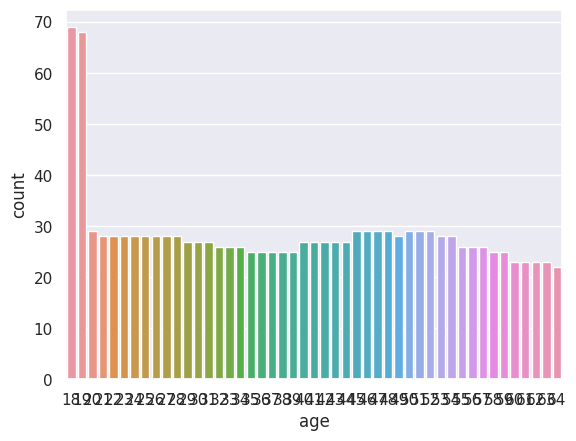

Summary for column: sex
        sex  Ratio
male    676 50.523
female  662 49.477
##########################################


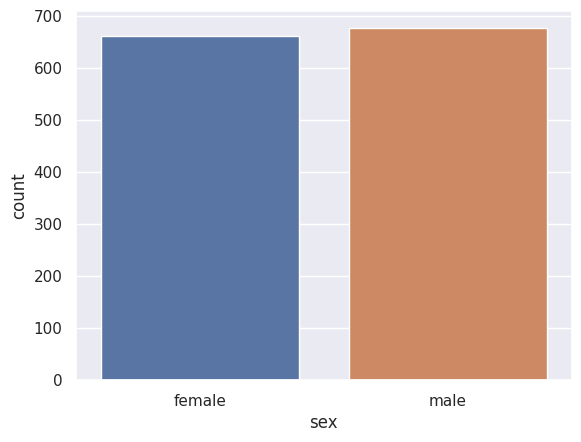

Summary for column: bmi
        bmi  Ratio
32.300   13  0.972
28.310    9  0.673
30.495    8  0.598
30.875    8  0.598
31.350    8  0.598
30.800    8  0.598
34.100    8  0.598
28.880    8  0.598
33.330    7  0.523
35.200    7  0.523
25.800    7  0.523
32.775    7  0.523
27.645    7  0.523
32.110    7  0.523
38.060    7  0.523
25.460    7  0.523
30.590    7  0.523
27.360    7  0.523
24.320    7  0.523
34.800    7  0.523
27.500    6  0.448
19.950    6  0.448
29.920    6  0.448
30.115    6  0.448
26.600    6  0.448
30.200    6  0.448
35.530    6  0.448
33.630    6  0.448
28.595    6  0.448
37.100    6  0.448
31.730    6  0.448
33.000    6  0.448
27.740    6  0.448
29.830    6  0.448
25.175    6  0.448
26.410    6  0.448
27.835    5  0.374
33.660    5  0.374
28.900    5  0.374
25.080    5  0.374
28.500    5  0.374
26.695    5  0.374
23.210    5  0.374
32.395    5  0.374
31.825    5  0.374
33.155    5  0.374
29.640    5  0.374
36.850    5  0.374
25.300    5  0.374
28.700    5  0.374
23.655 

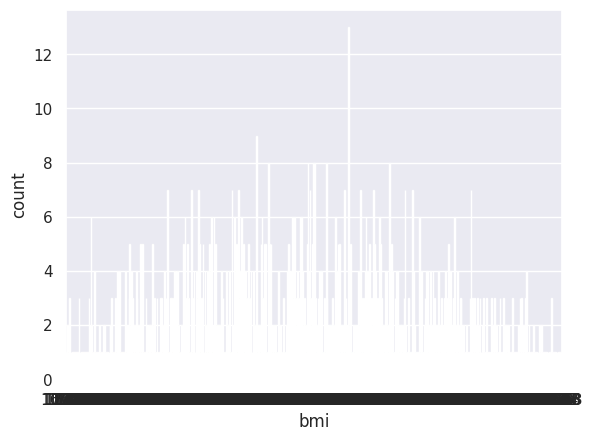

Summary for column: children
   children  Ratio
0       574 42.900
1       324 24.215
2       240 17.937
3       157 11.734
4        25  1.868
5        18  1.345
##########################################


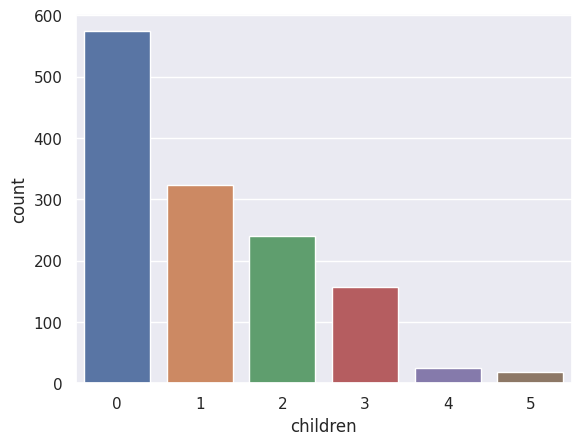

Summary for column: smoker
     smoker  Ratio
no     1064 79.522
yes     274 20.478
##########################################


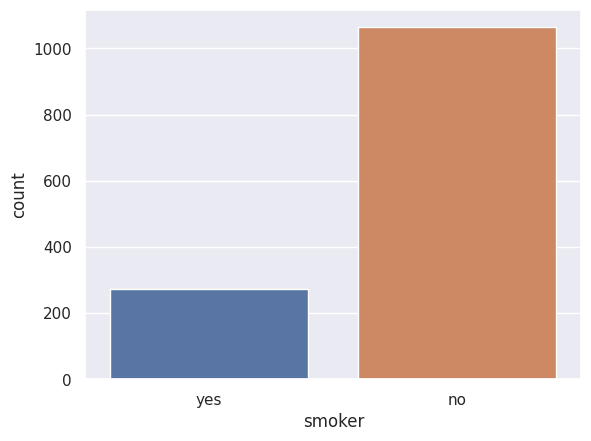

Summary for column: region
           region  Ratio
southeast     364 27.205
southwest     325 24.290
northwest     325 24.290
northeast     324 24.215
##########################################


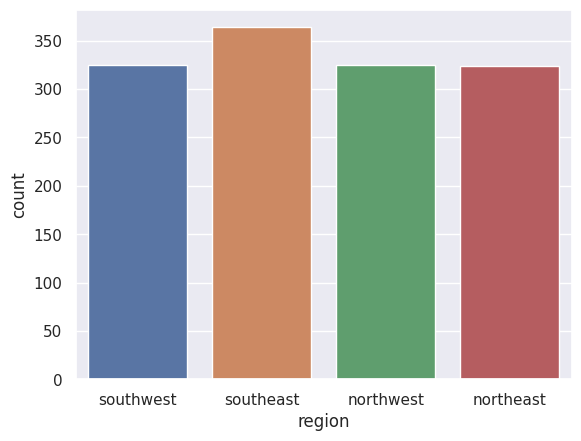

Summary for column: charges
           charges  Ratio
1639.563         2  0.149
16884.924        1  0.075
29330.983        1  0.075
2221.564         1  0.075
19798.055        1  0.075
13063.883        1  0.075
13555.005        1  0.075
44202.654        1  0.075
10422.917        1  0.075
7243.814         1  0.075
11945.133        1  0.075
6311.952         1  0.075
1682.597         1  0.075
5272.176         1  0.075
27218.437        1  0.075
19719.695        1  0.075
4877.981         1  0.075
46255.113        1  0.075
2585.851         1  0.075
2789.057         1  0.075
1634.573         1  0.075
2117.339         1  0.075
8688.859         1  0.075
48673.559        1  0.075
13041.921        1  0.075
35069.375        1  0.075
21774.322        1  0.075
2473.334         1  0.075
5257.508         1  0.075
7626.993         1  0.075
14382.709        1  0.075
33732.687        1  0.075
2639.043         1  0.075
17496.306        1  0.075
15170.069        1  0.075
7633.721         1  0.075
4846.920  

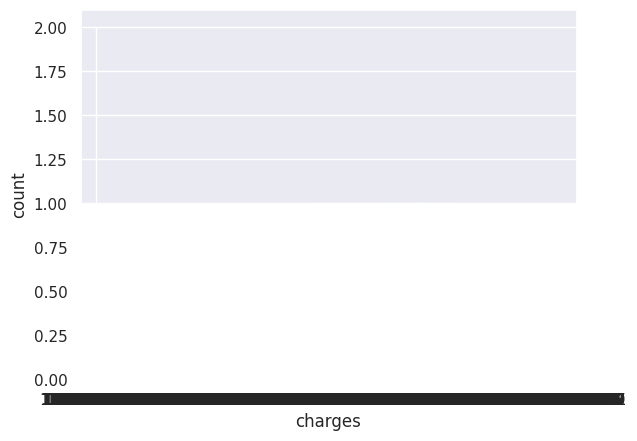

In [155]:
cat_summary(df, plot="True")

In [156]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    #cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1338
Variables: 7
cat_cols: 3
num_cols: 4
cat_but_car: 0


In [157]:
grab_col_names(df)

Observations: 1338
Variables: 7
cat_cols: 3
num_cols: 4
cat_but_car: 0


(['sex', 'smoker', 'region'], ['age', 'bmi', 'children', 'charges'], [])

In [158]:
#Numerik değer içeren sütunların özetini ve isteğe bağlı olarak grafiğini görebiliriz

def num_summary(dataframe, num_cols, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    for numerical_col in num_cols:
        print(f"Summary for numerical column: {numerical_col}")
        print(dataframe[numerical_col].describe(quantiles).T)
        print("##########################################")
        if plot:
            dataframe[numerical_col].hist(bins=20)
            plt.xlabel(numerical_col)
            plt.title(numerical_col)
            plt.show(block=True)

Summary for numerical column: age
count   1338.000
mean      39.207
std       14.050
min       18.000
5%        18.000
10%       19.000
20%       24.000
30%       29.000
40%       34.000
50%       39.000
60%       44.000
70%       49.000
80%       54.000
90%       59.000
95%       62.000
99%       64.000
max       64.000
Name: age, dtype: float64
##########################################


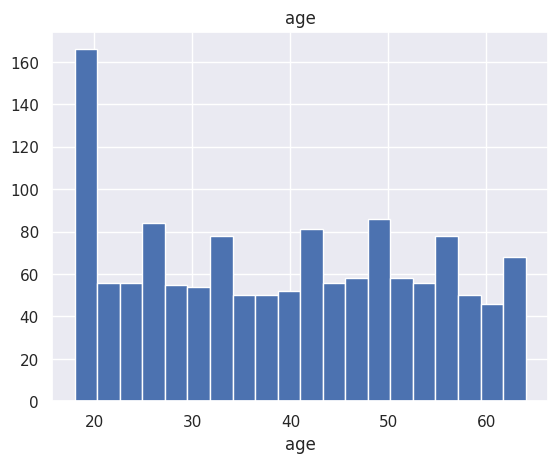

Summary for numerical column: bmi
count   1338.000
mean      30.663
std        6.098
min       15.960
5%        21.256
10%       22.990
20%       25.326
30%       27.360
40%       28.797
50%       30.400
60%       32.032
70%       33.660
80%       35.860
90%       38.619
95%       41.106
99%       46.408
max       53.130
Name: bmi, dtype: float64
##########################################


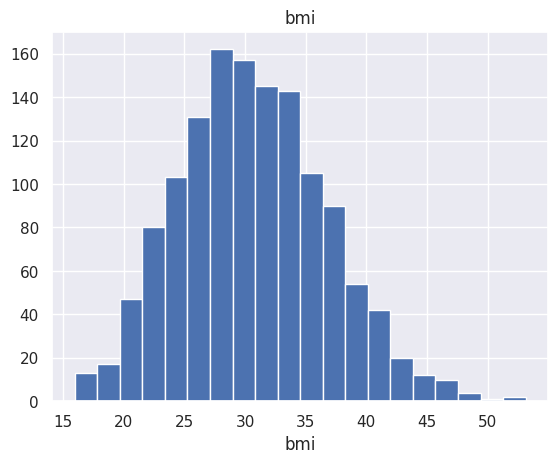

Summary for numerical column: children
count   1338.000
mean       1.095
std        1.205
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        1.000
60%        1.000
70%        2.000
80%        2.000
90%        3.000
95%        3.000
99%        5.000
max        5.000
Name: children, dtype: float64
##########################################


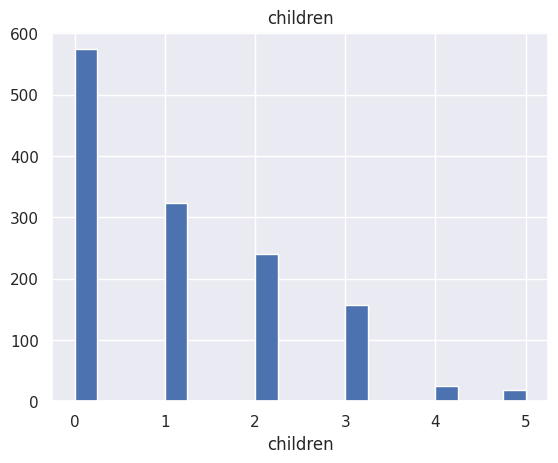

Summary for numerical column: charges
count    1338.000
mean    13270.422
std     12110.011
min      1121.874
5%       1757.753
10%      2346.534
20%      3991.576
30%      5484.847
40%      7369.053
50%      9382.033
60%     11399.857
70%     13767.875
80%     20260.626
90%     34831.720
95%     41181.828
99%     48537.481
max     63770.428
Name: charges, dtype: float64
##########################################


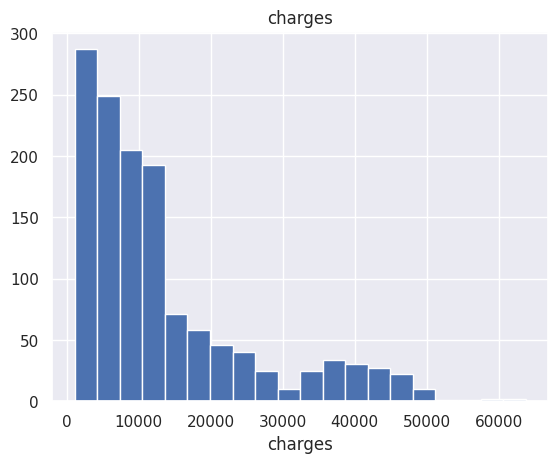

In [159]:
num_summary(df, num_cols, plot="True")

In [160]:
#sayısal değerlerin birbiri ile ilişkisi için kullanırız

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

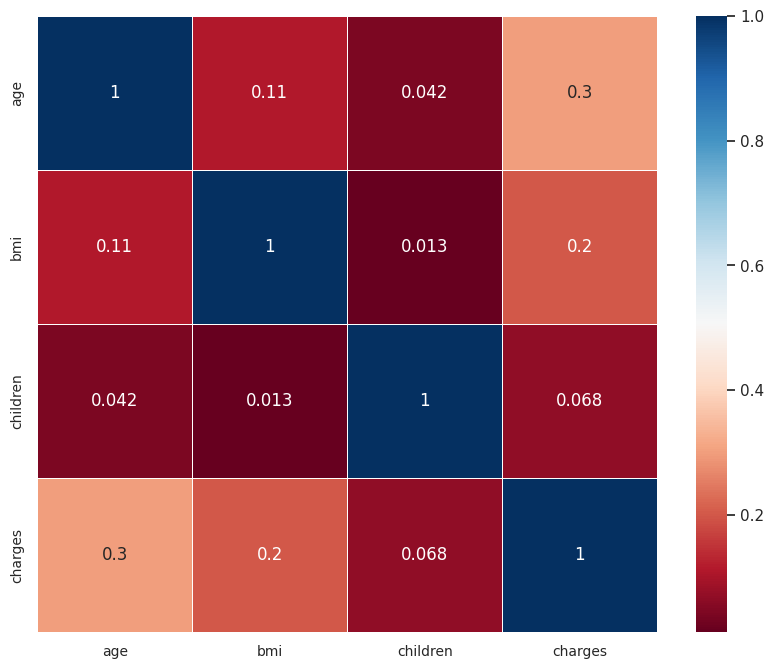

In [161]:
correlation_matrix(df, num_cols)

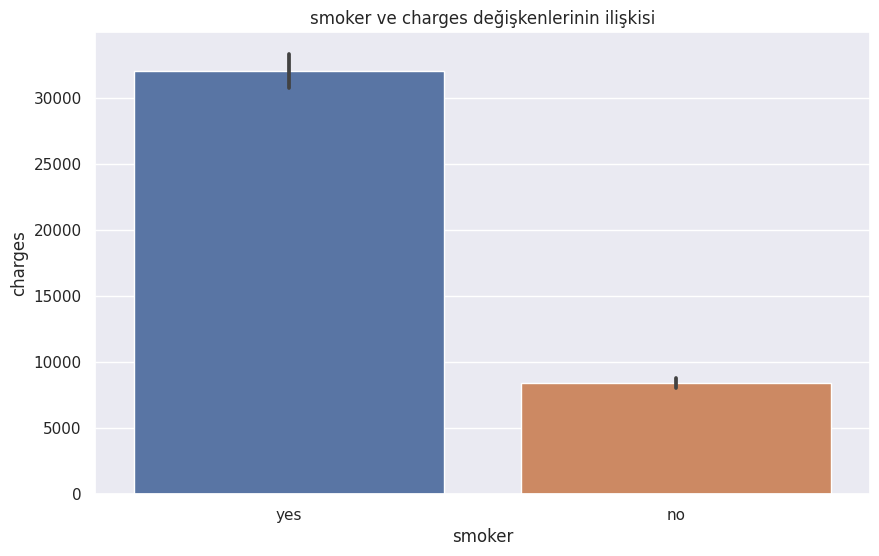

In [162]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='smoker', y='charges')
plt.xlabel('smoker')
plt.ylabel('charges')
plt.title('smoker ve charges değişkenlerinin ilişkisi')
plt.show()

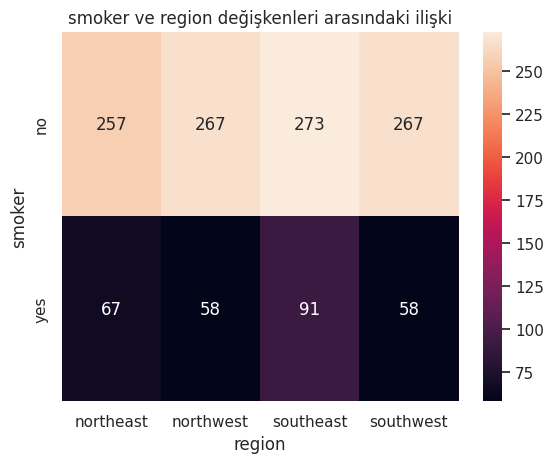

In [163]:
# Çapraz tablo oluşturma
cross_tab = pd.crosstab(df['smoker'], df['region'])

# Çapraz tabloyu görselleştirme
sns.heatmap(cross_tab, annot=True, fmt='d')
plt.xlabel('region')
plt.ylabel('smoker')
plt.title('smoker ve region değişkenleri arasındaki ilişki')
plt.show()


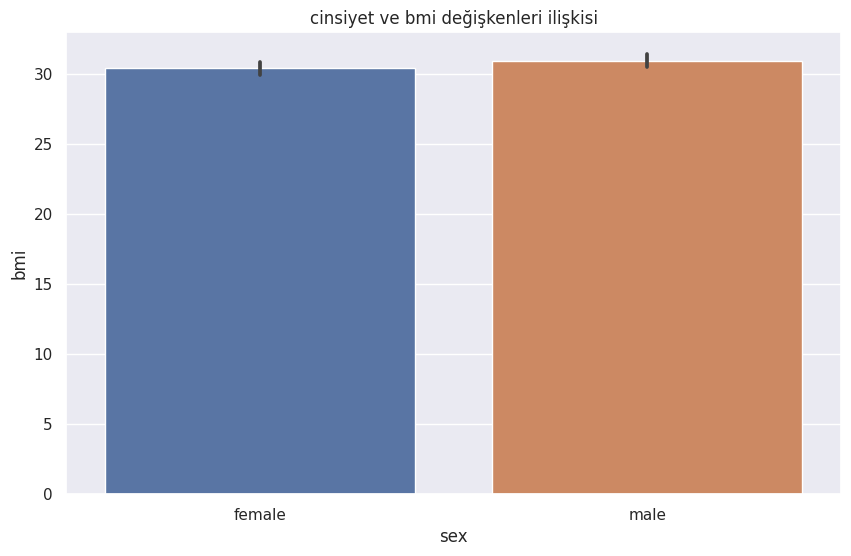

In [165]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='sex', y='bmi')
plt.xlabel('sex')
plt.ylabel('bmi')
plt.title('cinsiyet ve bmi değişkenleri ilişkisi')
plt.show()

region
southeast    382
northwest    373
southwest    371
northeast    339
Name: children, dtype: int64


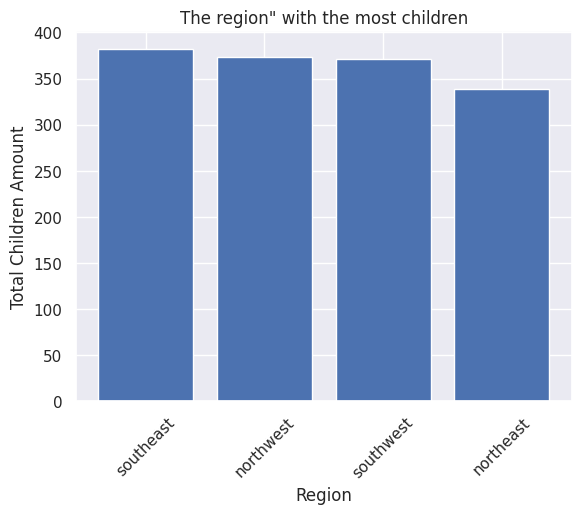

In [166]:
# Bölgelere göre gruplama ve çocuk sayılarını toplama
grouped = df.groupby('region')['children'].sum()

# Çocuk sayılarına göre sıralama
sorted_grouped = grouped.sort_values(ascending=False)

# En çok çocuğa sahip bölgeleri gösterme
print(sorted_grouped)

# görselleştirme

plt.bar(sorted_grouped.index, sorted_grouped.values)
plt.xlabel('Region')
plt.ylabel('Total Children Amount')
plt.title('The region" with the most children')
plt.xticks(rotation=45)
plt.show()

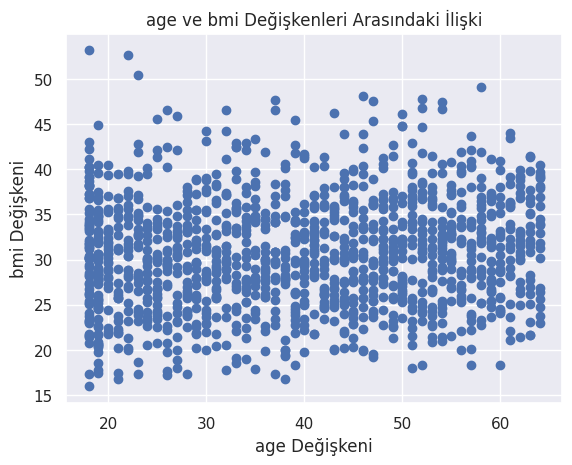

In [167]:
plt.scatter(df['age'], df['bmi'])
plt.xlabel('age Değişkeni')
plt.ylabel('bmi Değişkeni')
plt.title('age ve bmi Değişkenleri Arasındaki İlişki')
plt.show()

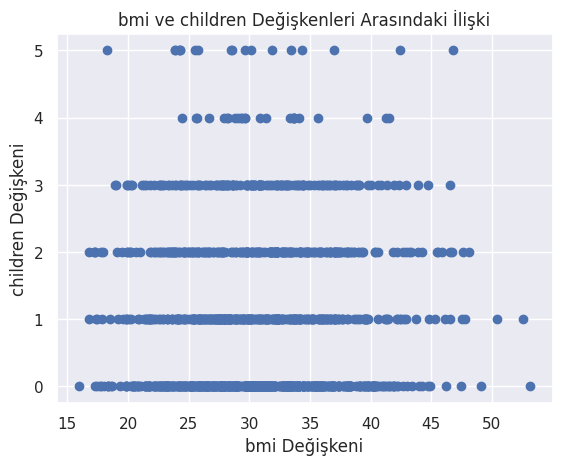

In [168]:
plt.scatter(df['bmi'], df['children'])
plt.xlabel('bmi Değişkeni')
plt.ylabel('children Değişkeni')
plt.title('bmi ve children Değişkenleri Arasındaki İlişki')
plt.show()

In [169]:
#outlier eşik değerler için bir fonksiyon

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
outlier_thresholds(df, "bmi")

(13.7, 47.290000000000006)

In [ ]:
#outlier değer varlığına dair bir fonksiyon

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


In [ ]:
low, up = outlier_thresholds(df, "bmi")

In [ ]:
check_outlier(df, "bmi")

True

In [ ]:
#outlier değerleri getirir

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [ ]:
grab_outliers(df, "bmi")

      age     sex    bmi  children smoker     region      charges
116    58    male  49.06         0     no  southeast  11381.32540
286    46  female  48.07         2     no  northeast   9432.92530
401    47    male  47.52         1     no  southeast   8083.91980
543    54  female  47.41         0    yes  southeast  63770.42801
847    23    male  50.38         1     no  southeast   2438.05520
860    37  female  47.60         2    yes  southwest  46113.51100
1047   22    male  52.58         1    yes  southeast  44501.39820
1088   52    male  47.74         1     no  southeast   9748.91060
1317   18    male  53.13         0     no  southeast   1163.46270


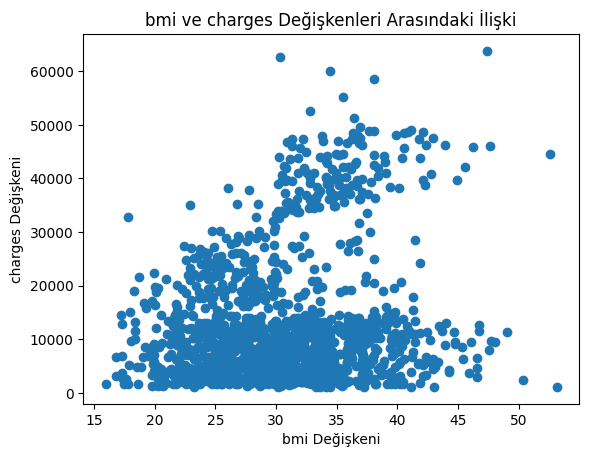

In [ ]:
plt.scatter(df['bmi'], df['charges'])
plt.xlabel('bmi Değişkeni')
plt.ylabel('charges Değişkeni')
plt.title('bmi ve charges Değişkenleri Arasındaki İlişki')
plt.show()

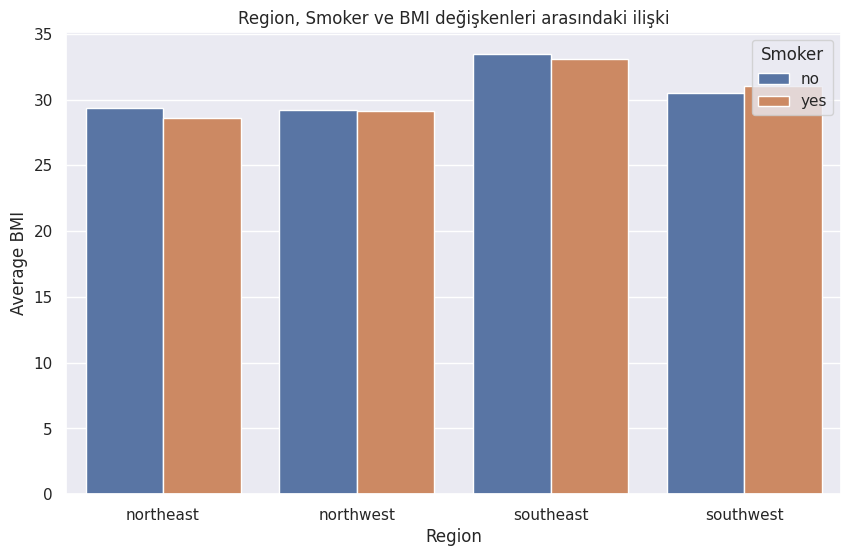

In [170]:
# Group by "region" ve "smoker" ve ortalama BMI hesabı
bmi_by_region_smoker = df.groupby(["region", "smoker"])["bmi"].mean().reset_index()

# Görselleştirme
plt.figure(figsize=(10, 6))
sns.barplot(data=bmi_by_region_smoker, x="region", y="bmi", hue="smoker")
plt.xlabel("Region")
plt.ylabel("Average BMI")
plt.title("Region, Smoker ve BMI değişkenleri arasındaki ilişki")
plt.legend(title="Smoker")
plt.show()

In [171]:
# numerik kolonlarda gezerek outlier değer varlığı sorgulama:

for col in num_cols:
    print(col, check_outlier(df, col))

age False
bmi True
children False
charges True


In [ ]:
#outlier değerleri eşik değerleri ile değiştirme

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [ ]:
replace_with_thresholds(df, "bmi")
replace_with_thresholds(df, "charges")

In [ ]:
for col in num_cols:
    print(col, check_outlier(df, col))

age False
bmi False
children False
charges False


In [ ]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [ ]:
cat_cols

['sex', 'smoker', 'region']

In [ ]:
#numerik değerleri 0-1 arasına ölçeklendirme

scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
#kategorik değerleri sayısal değerlere encode etme

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [ ]:
df = one_hot_encoder(df, cat_cols)
df.head(10)

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.381104,0.0,0.472408,1,0,0,1,0,0,0,1
1,0.000000,0.568465,0.2,0.018092,0,1,1,0,0,0,1,0
2,0.217391,0.543888,0.6,0.099725,0,1,1,0,0,0,1,0
3,0.326087,0.215289,0.0,0.625237,0,1,1,0,0,1,0,0
4,0.304348,0.412384,0.0,0.082265,0,1,1,0,0,1,0,0
5,0.282609,0.312161,0.0,0.078962,1,0,1,0,0,0,1,0
6,0.608696,0.557932,0.2,0.213343,1,0,1,0,0,0,1,0
7,0.413043,0.375997,0.6,0.184600,1,0,1,0,0,1,0,0
8,0.413043,0.442707,0.4,0.158374,0,1,1,0,1,0,0,0
9,0.913043,0.315353,0.0,0.833184,1,0,1,0,0,1,0,0


In [ ]:
# Özellikler ve hedef değişkeni olarak ayrılacak sütunları belirleme
X = df.drop("charges", axis=1)
y = df["charges"]

# Veriyi eğitim ve test alt kümelerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#ondalıkların sonrasında iki dijit olsun

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
df.head(10)

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.02,0.38,0.00,0.47,1,0,0,1,0,0,0,1
1,0.00,0.57,0.20,0.02,0,1,1,0,0,0,1,0
2,0.22,0.54,0.60,0.10,0,1,1,0,0,0,1,0
3,0.33,0.22,0.00,0.63,0,1,1,0,0,1,0,0
4,0.30,0.41,0.00,0.08,0,1,1,0,0,1,0,0
5,0.28,0.31,0.00,0.08,1,0,1,0,0,0,1,0
6,0.61,0.56,0.20,0.21,1,0,1,0,0,0,1,0
7,0.41,0.38,0.60,0.18,1,0,1,0,0,1,0,0
8,0.41,0.44,0.40,0.16,0,1,1,0,1,0,0,0
9,0.91,0.32,0.00,0.83,1,0,1,0,0,1,0,0


In [125]:
#regresyon modelleri belirlenerek model oluşturulur, rmse skorları hesaplanır

models = [('LR', LinearRegression()),
          #("Ridge", Ridge()),
          #("Lasso", Lasso()),
          #("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          #('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]
          # ("CatBoost", CatBoostRegressor(verbose=False))]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 0.1534 (LR) 
RMSE: 0.1541 (KNN) 
RMSE: 0.1893 (CART) 
RMSE: 0.137 (RF) 
RMSE: 0.1296 (GBM) 
RMSE: 0.1508 (XGBoost) 
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 11
[LightGBM] [Info] Start training from score 0.337772
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 11
[LightGBM] [Info] Start training from score 0.341126
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_co

RMSE değeri en düşük GBM'de geldi, hiperparametre optimizasyonunu bu modele uygulayacağız

In [126]:
#modele GridSearch uygulama ve en iyi hiperparametreleri belirleme

lgbm_model = LGBMRegressor(random_state=46)

rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model, X, y, cv=5, scoring="neg_mean_squared_error")))


lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1500],
               "colsample_bytree": [0.5, 0.7, 1]}

lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=True).fit(X, y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 11
[LightGBM] [Info] Start training from score 0.337772
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 11
[LightGBM] [Info] Start training from score 0.341126
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 11
[LightGBM] [Info] Start 

In [128]:
#en iyi hiper parametrelere göre final modeli kurma

final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 1338, number of used features: 11
[LightGBM] [Info] Start training from score 0.340376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [129]:
#final model ile rmse değeri hesaplama

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 11
[LightGBM] [Info] Start training from score 0.337772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 11
[LightGBM] [Info] Start training from score 0.341126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [131]:
lgbm_gs_best.get_params()
lgbm_gs_best.best_params_

{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500}

In [130]:
rmse

0.12997578047297104

RMSE değeri hiperparametre optimizasyonu sonrası daha iyi bir değer vermiştir.